### Imports

In [1]:
import sys
sys.path.insert(0, 'D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\Classes')

import warnings
warnings.filterwarnings('ignore')

from models import ClassificationModel, EmbeddingsModel, SiameseModel
from trainer import SiameseTrainerCombinationDataset, all_subjects

import torch
import json

### Set Hyperparameters

In [18]:
subjects_test = [all_subjects[0]]
subjects_train = [sub for sub in all_subjects if sub not in subjects_test]

In [38]:
trainer_hyperparameter = {
    "path": "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\FeatureGeneration\dataset_processed\XITE\\normalized_subjects_no_outliner.pkl",
    "subjects_train": subjects_train,
    "subjects_test": subjects_test,
    "wandb": False,
    "log": True,
    "learning_rate": 0.01,
    "batch_size": 256,
    "batch_size_test": 256,
    "freeze_embed": False,
    "dataset_ignore_subject_train": True,
    "dataset_ignore_subject_test": False,
    "decision_function": 0,
    "filter": [1, 2, 3, 4, 5, 6, -1, -2, -3, -4, -5, -6],
    "weight_decay": None,
    "lr_steps": 10,
    "number_steps": 200,
    "number_steps_testing": 200
}

model_embedding_hyperparameter = {
        "sigmoid": False,
        "dropout": 0.2,
        "layers": [207, 512, 64]
}

model_classifier_hyperparameter = {
    "dropout": 0.2,
    "layers": [64, 32]
}

### Init models

In [39]:
classifier_model = ClassificationModel(model_classifier_hyperparameter)
embedding_model = EmbeddingsModel(model_embedding_hyperparameter)

siamese_model = SiameseModel(embedding_model, classifier_model, decision_function=trainer_hyperparameter["decision_function"])

# #
#  0 = abs(sub())
#  1 = euclid
#  2 = cos_simil
# #

In [40]:
_ = embedding_model.load_state_dict(torch.load("D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\Results\models\embedding_models\model_abs_acc_89.40.pth"))

In [41]:
filter = lambda data: data["label"].isin(trainer_hyperparameter["filter"])
trainer = SiameseTrainerCombinationDataset(trainer_hyperparameter, siamese_model, device="cuda:0", filter=filter)

### start training

In [42]:
trainer.trainloop(100)

{'epoch': 1, 'train': {'loss': tensor(0.6448), 'acc': tensor(0.6131)}, 'test': {'loss': tensor(0.5671), 'acc': tensor(0.7122)}}
{'epoch': 2, 'train': {'loss': tensor(0.6262), 'acc': tensor(0.6327)}, 'test': {'loss': tensor(0.5351), 'acc': tensor(0.7366)}}
{'epoch': 3, 'train': {'loss': tensor(0.6181), 'acc': tensor(0.6368)}, 'test': {'loss': tensor(0.5215), 'acc': tensor(0.7593)}}
{'epoch': 4, 'train': {'loss': tensor(0.6137), 'acc': tensor(0.6404)}, 'test': {'loss': tensor(0.5189), 'acc': tensor(0.7512)}}
{'epoch': 5, 'train': {'loss': tensor(0.6099), 'acc': tensor(0.6474)}, 'test': {'loss': tensor(0.4938), 'acc': tensor(0.7762)}}
{'epoch': 6, 'train': {'loss': tensor(0.6091), 'acc': tensor(0.6419)}, 'test': {'loss': tensor(0.5141), 'acc': tensor(0.7735)}}
{'epoch': 7, 'train': {'loss': tensor(0.6042), 'acc': tensor(0.6532)}, 'test': {'loss': tensor(0.4872), 'acc': tensor(0.7831)}}
{'epoch': 8, 'train': {'loss': tensor(0.6024), 'acc': tensor(0.6530)}, 'test': {'loss': tensor(0.4792), 

 72%|███████▏  | 143/200 [00:59<00:23,  2.41it/s]


KeyboardInterrupt: 

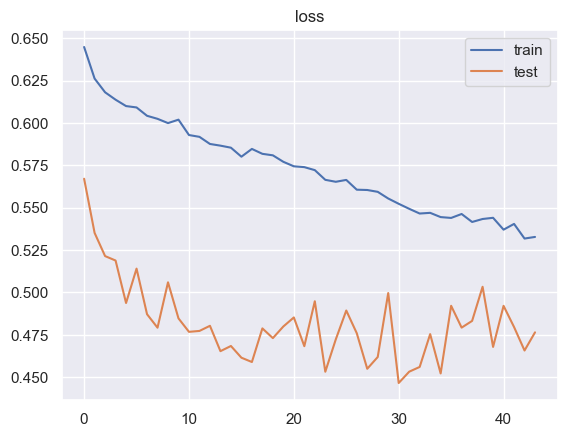

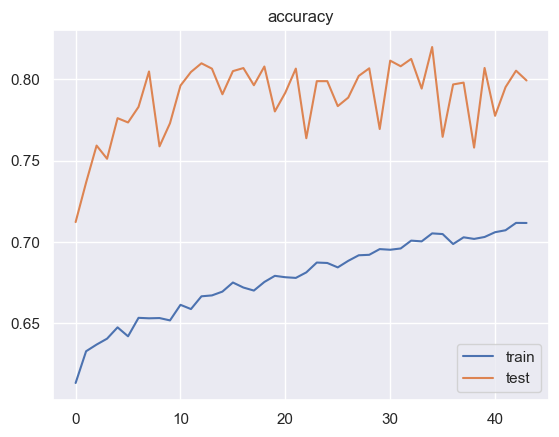

In [43]:
trainer.plot_history()

### Save best testing result to file

In [44]:
best_acc = max([x["test"]["acc"] for x in trainer.history])
print(best_acc)

tensor(0.8200)


In [45]:
epochs = len(trainer.history)

path = "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\Results\siamese_model_results\combination_dataset.json"
trainer_hyp = trainer_hyperparameter.copy()
del trainer_hyp["subjects_train"]
del trainer_hyp["path"]
del trainer_hyp["wandb"]
del trainer_hyp["log"]

data_to_save = [{"trainer_hyperparameter": trainer_hyp,
        "model_embedding_hyperparameter": model_embedding_hyperparameter,
        "model_classifier_hyperparameter": model_classifier_hyperparameter,
        "acc": best_acc.item(),
        "epochs": epochs}]
        
try:
    with open(path) as infile:
        data = json.load(infile)
except:
    data = []

data.extend(data_to_save)
with open(path, 'w') as fp:
    json.dump(data, fp, sort_keys=True, indent=4)